In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

data=pd.read_csv('Bitcoin2020.csv')

In [ ]:
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1609459140,12/31/2020 23:59,BTC/USD,28982.44,29024.59,28969.83,28992.79,5.897679,170990.18290
1,1609459080,12/31/2020 23:58,BTC/USD,29044.79,29048.62,29000.12,29000.12,20.362289,590508.83780
2,1609459020,12/31/2020 23:57,BTC/USD,29039.53,29048.63,29023.26,29044.79,14.503728,421257.72150
3,1609458960,12/31/2020 23:56,BTC/USD,29052.02,29059.42,29039.28,29039.53,2.707583,78626.92585
4,1609458900,12/31/2020 23:55,BTC/USD,29036.10,29052.02,29025.78,29052.02,7.631439,221708.70540


In [ ]:
data.set_index('date', inplace=True)
data.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
12/31/2020 23:59,1609459140,BTC/USD,28982.44,29024.59,28969.83,28992.79,5.897679,170990.18290
12/31/2020 23:58,1609459080,BTC/USD,29044.79,29048.62,29000.12,29000.12,20.362289,590508.83780
12/31/2020 23:57,1609459020,BTC/USD,29039.53,29048.63,29023.26,29044.79,14.503728,421257.72150
12/31/2020 23:56,1609458960,BTC/USD,29052.02,29059.42,29039.28,29039.53,2.707583,78626.92585
12/31/2020 23:55,1609458900,BTC/USD,29036.10,29052.02,29025.78,29052.02,7.631439,221708.70540


In [ ]:
columns_to_drop = ['unix', 'symbol', 'open', 'high', 'low', 'Volume BTC', 'Volume USD']
data.drop(columns=columns_to_drop, inplace=True)
data.head()

,close
date,
12/31/2020 23:59,28992.79
12/31/2020 23:58,29000.12
12/31/2020 23:57,29044.79
12/31/2020 23:56,29039.53
12/31/2020 23:55,29052.02


In [ ]:
data.index = pd.to_datetime(data.index)
data.index = data.index.strftime('%Y-%m-%d %H:%M:%S')
data.head()

,close
date,
2020-12-31 23:59:00,28992.79
2020-12-31 23:58:00,29000.12
2020-12-31 23:57:00,29044.79
2020-12-31 23:56:00,29039.53
2020-12-31 23:55:00,29052.02


In [ ]:
nof_missing_values = sum(np.isnan(data['close']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(data)))

0 observations are missing.
This is 0.000% of the total.


In [ ]:
use_features = ['close']
target = ['close']
n_steps_ahead = 4

In [ ]:
data.shape

(487722, 1)

In [ ]:
sample = data['close'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [ ]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -4.804083497201604
p-value: 5.34161017932025e-05,
N: 199934, 
critical values: {'1%': -3.4303827077133437, '5%': -2.8615544563764943, '10%': -2.566777694609469}


In [ ]:
pacf = sm.tsa.stattools.pacf(data[use_features], nlags=30)

In [ ]:
T = len(data[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [ ]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 3


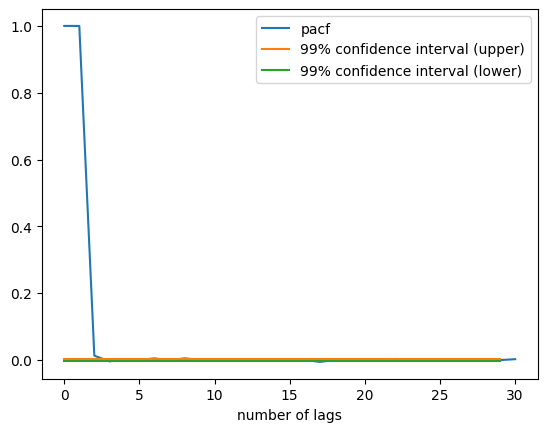

In [ ]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

In [ ]:
use_features = ['close'] # continuous input
target = ['close'] # continuous output
n_steps_ahead = 3 # forecasting horizon

In [ ]:
train_weight = 0.8
split = int(len(data) * train_weight)

df_train = data[use_features].iloc[:split]
df_test = data[use_features].iloc[split:]

In [ ]:
# note that for a multivariate time series, you would need to scale
# each variable by its own mean and standard deviation in the training set
mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)


<ipython-input-30-eb25e364d756>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(df_train.mean())
<ipython-input-30-eb25e364d756>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(df_train.std())


In [ ]:
df_train.head()

,close
date,
2020-12-31 23:59:00,4.544767
2020-12-31 23:58:00,4.546597
2020-12-31 23:57:00,4.557747
2020-12-31 23:56:00,4.556434
2020-12-31 23:55:00,4.559552


In [ ]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []

    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [ ]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [ ]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(390172, 3, 1), (390172, 1), (97540, 3, 1), (97540, 1)]


In [ ]:
max_epochs = 20
batch_size = 1000

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Train Loss: 0.3300703167915344, Test Loss: 0.022357383742928505
Epoch 2/20, Train Loss: 0.4143204092979431, Test Loss: 0.14474861323833466
Epoch 3/20, Train Loss: 0.12763972580432892, Test Loss: 0.03187920153141022
Epoch 4/20, Train Loss: 0.07546438276767731, Test Loss: 0.022183122113347054
Epoch 5/20, Train Loss: 0.03584911674261093, Test Loss: 0.005706263240426779
Epoch 6/20, Train Loss: 0.02550462633371353, Test Loss: 0.0021635929588228464
Epoch 7/20, Train Loss: 0.020349988713860512, Test Loss: 0.0009305001585744321
Epoch 8/20, Train Loss: 0.018482280895113945, Test Loss: 0.0004109718429390341
Epoch 9/20, Train Loss: 0.01792687363922596, Test Loss: 0.00022080836060922593
Epoch 10/20, Train Loss: 0.017572378739714622, Test Loss: 0.00016925579984672368
Epoch 11/20, Train Loss: 0.01684761792421341, Test Loss: 0.00017501830006949604
Epoch 12/20, Train Loss: 0.015917513519525528, Test Loss: 0.00016949819109868258
Epoch 13/20, Train Loss: 0.014994901604950428, Test Loss: 0.00

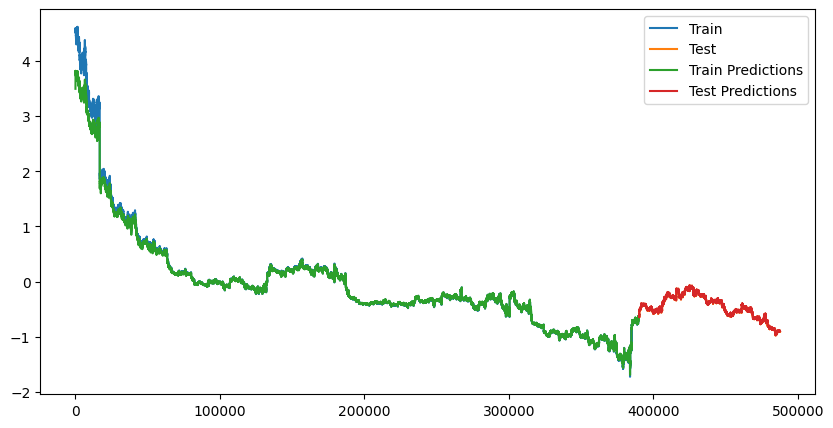

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


# Define the GRU model class
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1, dropout=0.0):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train).float()
y_train_tensor = torch.tensor(y_train).float()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test).float()


train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

# instantiate the GRU model
# define the GRU model hyperparameters
input_size = x_train.shape[-1]  # number of features in input data
hidden_size = 64  # number of hidden units in the GRU layer
output_size = 1  # number of output units

# instantiate the GRU model

gru_model = GRU(input_size, hidden_size, output_size)

# define the loss function, optimizer, and learning rate scheduler
criterion = nn.MSELoss()
optimizer = Adam(gru_model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

# training the model
num_epochs = 20
for epoch in range(num_epochs):
    gru_model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # evaluate the model
    gru_model.eval()
    with torch.no_grad():
        train_preds = gru_model(x_train_tensor)
        train_loss = criterion(train_preds, y_train_tensor)
        test_preds = gru_model(x_test_tensor)
        test_loss = criterion(test_preds, y_test_tensor)

    # update the learning rate scheduler
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}')


plt.figure(figsize=(10, 5))
plt.plot(y_train, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(range(len(y_train)), train_preds.detach().numpy(), label='Train Predictions')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_preds.detach().numpy(), label='Test Predictions')
plt.legend()
plt.show()


In [ ]:
# calculate Mean Squared Error (MSE) for training and testing predictions
train_mse = mean_squared_error(y_train, train_preds.numpy())
test_mse = mean_squared_error(y_test, test_preds.numpy())

print(f'Training MSE: {train_mse}')
print(f'Testing MSE: {test_mse}')


Training MSE: 0.011624395918066239
Testing MSE: 1.929568768213417e-05
